In [1]:

import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from os import listdir
from PIL import Image

import shutil

import matplotlib.pyplot as plt
import sys
print(sys.executable)
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print (DEVICE)


/usr/bin/python3
cpu


In [2]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 1

IMG_SIZE = 32
N_CLASSES = 18

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def plot_accuracy(train_accuracies, valid_accuracies):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_accuracies = np.array(train_accuracies) 
    valid_accuracies = np.array(valid_accuracies)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_accuracies, color='blue', label='Training accuracy') 
    ax.plot(valid_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    


In [4]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [5]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        
        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    
    
    return model, epoch_loss

In [6]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            train_accuracies.append(train_acc)
            valid_accuracies.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    plot_accuracy(train_accuracies, valid_accuracies)

    
    return model, optimizer, (train_losses, valid_losses)


In [7]:
# define transforms
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])



# download and create datasets
train_dataset = datasets.ImageFolder(root='train', 
                               transform=transform)

valid_dataset = datasets.ImageFolder(root='test', 
                               transform=transform)

# define the data loaders

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root='train',
                        transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root='test',  transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)


In [8]:
class LeNet5_16_32(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5_16_32, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=5*5*32, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=N_CLASSES),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [9]:

torch.manual_seed(RANDOM_SEED)

model = LeNet5_16_32(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

13:03:20 --- Epoch: 0	Train loss: 0.1099	Valid loss: 0.0039	Train accuracy: 99.94	Valid accuracy: 99.92


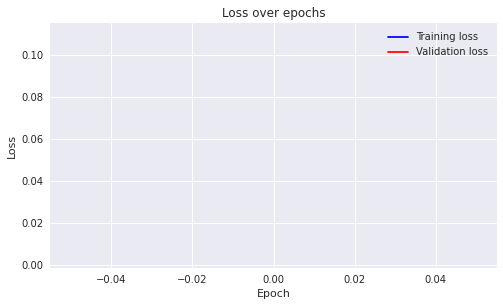

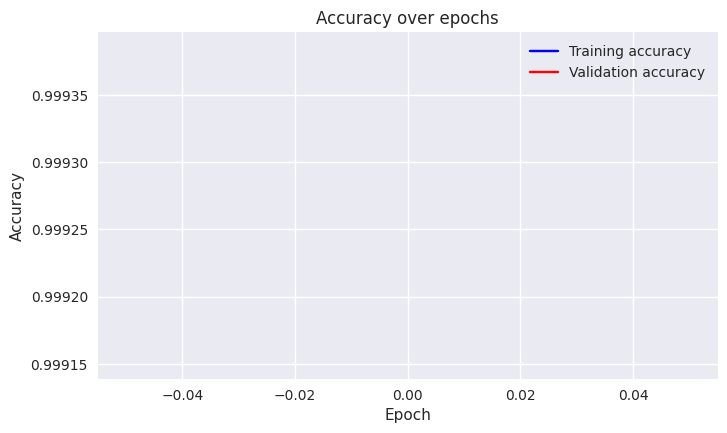

In [10]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)



In [11]:

sum(p.numel() for p in model.parameters())

95166

In [15]:
torch.save(model, "../models/lenet5_16_32.pt")

/home/paf2020/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
model.eval()
CM = torch.zeros(N_CLASSES,N_CLASSES, dtype = torch.int)#class_num is the number of classes... 20
with torch.no_grad():
    for i, (images, target) in enumerate(train_loader):#validation set loader
        output = model(images)
        pred = torch.argmax(output[1], 1)
        for i in range(len(target)):
            CM[target[i], pred[i]] += 1


In [12]:
print(CM)

tensor([[5860,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0, 4071,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0,    0, 5422,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0,    0,    0, 6946,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0, 5424,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 5780,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0, 6946,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0, 6063,    0,    0,    0,    0,
            0,    0,    0,    

In [13]:
model.eval()
CM = torch.zeros(N_CLASSES,N_CLASSES, dtype = torch.int)#class_num is the number of classes... 20
with torch.no_grad():
    for i, (images, target) in enumerate(valid_loader):#validation set loader
        output = model(images)
        pred = torch.argmax(output[1], 1)
        for i in range(len(target)):
            CM[target[i], pred[i]] += 1


In [14]:
print(CM)

tensor([[636,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0, 428,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0, 575,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0, 804,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0, 573,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 718,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 801,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 684,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 429,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0, 